In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dataclasses import dataclass
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
@dataclass
class Config:
    RANDOM_SEED: int = 42
    FIGURE_SIZE: Tuple[int, int] = (12, 8)
    COLOR_PALETTE: str = "viridis"

config = Config()
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette(config.COLOR_PALETTE)


In [3]:
# 1. Data Loading
def load_data(filepath: str) -> pd.DataFrame:
    """Load and validate credit risk dataset."""
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    return df

# 2. Data Overview
def data_overview(df: pd.DataFrame) -> Dict:
    """Generate comprehensive data overview."""
    overview = {
        'shape': df.shape,
        'dtypes': df.dtypes.value_counts().to_dict(),
        'missing_values': df.isnull().sum().sort_values(ascending=False),
        'duplicates': df.duplicated().sum(),
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
    }
    return overview

# 3. Summary Statistics
def detailed_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Generate detailed summary statistics."""
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'missing': df.isnull().sum(),
        'missing_pct': (df.isnull().sum() / len(df) * 100),
        'unique': df.nunique(),
        'cardinality': df.nunique() / len(df),
        'mean': df.select_dtypes(include=[np.number]).mean(),
        'std': df.select_dtypes(include=[np.number]).std(),
        'min': df.select_dtypes(include=[np.number]).min(),
        '25%': df.select_dtypes(include=[np.number]).quantile(0.25),
        '50%': df.select_dtypes(include=[np.number]).quantile(0.50),
        '75%': df.select_dtypes(include=[np.number]).quantile(0.75),
        'max': df.select_dtypes(include=[np.number]).max()
    })
    return summary

In [4]:
# 4. Distribution Analysis
def plot_numerical_distributions(df: pd.DataFrame, columns: List[str], n_cols: int = 3):
    """Plot distributions of numerical features."""
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()
    
    for idx, col in enumerate(columns):
        if idx < len(axes):
            ax = axes[idx]
            df[col].hist(bins=50, ax=ax, edgecolor='black')
            ax.set_title(f'{col} Distribution')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            
            # Add statistics
            stats_text = f'Mean: {df[col].mean():.2f}\nStd: {df[col].std():.2f}\nSkew: {df[col].skew():.2f}'
            ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide empty subplots
    for idx in range(len(columns), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [5]:
# 5. Categorical Analysis
def plot_categorical_distributions(df: pd.DataFrame, columns: List[str], top_n: int = 10):
    """Plot distributions of categorical features."""
    for col in columns:
        if df[col].nunique() > top_n:
            # For high cardinality features, show top N
            value_counts = df[col].value_counts().head(top_n)
            title = f'Top {top_n} Categories for {col}'
        else:
            value_counts = df[col].value_counts()
            title = f'Distribution of {col}'
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Bar plot
        bars = ax1.bar(value_counts.index.astype(str), value_counts.values)
        ax1.set_title(title)
        ax1.set_xlabel(col)
        ax1.set_ylabel('Count')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,}', ha='center', va='bottom')
        
        # Pie chart (if not too many categories)
        if len(value_counts) <= 8:
            ax2.pie(value_counts.values, labels=value_counts.index.astype(str), autopct='%1.1f%%')
            ax2.set_title(f'Percentage Distribution')
        
        plt.tight_layout()
        plt.show()


In [6]:

# 6. Correlation Analysis
def plot_correlation_matrix(df: pd.DataFrame, numerical_cols: List[str]):
    """Plot correlation matrix for numerical features."""
    corr_matrix = df[numerical_cols].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8},
                annot=True, fmt='.2f', annot_kws={'size': 8})
    
    plt.title('Correlation Matrix of Numerical Features', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Identify high correlations
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                 corr_matrix.iloc[i, j]))
    
    return high_corr

# 7. Missing Values Analysis
def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Detailed missing values analysis."""
    missing_df = pd.DataFrame({
        'column': df.columns,
        'missing_count': df.isnull().sum().values,
        'missing_pct': (df.isnull().sum() / len(df) * 100).values,
        'dtype': df.dtypes.values
    }).sort_values('missing_pct', ascending=False)
    
    # Plot missing values
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(missing_df['column'][:20], missing_df['missing_pct'][:20])
    ax.set_xlabel('Missing Percentage')
    ax.set_title('Top 20 Features with Missing Values')
    ax.invert_yaxis()
    
    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
               f'{width:.1f}%', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return missing_df


In [7]:

# 8. Outlier Detection
def detect_outliers(df: pd.DataFrame, numerical_cols: List[str], threshold: float = 1.5):
    """Detect outliers using IQR method."""
    outlier_summary = {}
    
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_pct = (len(outliers) / len(df)) * 100
        
        outlier_summary[col] = {
            'outlier_count': len(outliers),
            'outlier_pct': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min': df[col].min(),
            'max': df[col].max()
        }
        
        # Box plot for each feature
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Box plot
        ax1.boxplot(df[col].dropna())
        ax1.set_title(f'{col} - Box Plot')
        ax1.set_ylabel(col)
        
        # Distribution with outlier bounds
        ax2.hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
        ax2.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
        ax2.set_title(f'{col} - Distribution with Outlier Bounds')
        ax2.set_xlabel(col)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame(outlier_summary).T


In [8]:

# 9. Target Variable Analysis
def analyze_target(df: pd.DataFrame, target_col: str):
    """Analyze target variable distribution."""
    if target_col in df.columns:
        target_dist = df[target_col].value_counts(normalize=True) * 100
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Bar plot
        bars = ax1.bar(target_dist.index.astype(str), target_dist.values)
        ax1.set_title(f'Target Distribution: {target_col}')
        ax1.set_xlabel('Class')
        ax1.set_ylabel('Percentage')
        
        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        # Pie chart
        ax2.pie(target_dist.values, labels=target_dist.index.astype(str), 
                autopct='%1.1f%%', startangle=90)
        ax2.set_title(f'Class Distribution')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Class Distribution:\n{target_dist}")
        print(f"\nClass Imbalance Ratio: {target_dist.max() / target_dist.min():.2f}:1")


In [9]:

# 10. Time Series Analysis (if applicable)
def analyze_temporal_patterns(df: pd.DataFrame, date_col: str, target_col: str = None):
    """Analyze temporal patterns in data."""
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df['year'] = df[date_col].dt.year
        df['month'] = df[date_col].dt.month
        df['quarter'] = df[date_col].dt.quarter
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Monthly trend
        monthly_counts = df.groupby('month').size()
        axes[0, 0].plot(monthly_counts.index, monthly_counts.values, marker='o')
        axes[0, 0].set_title('Monthly Application Volume')
        axes[0, 0].set_xlabel('Month')
        axes[0, 0].set_ylabel('Count')
        
        # Yearly trend
        yearly_counts = df.groupby('year').size()
        axes[0, 1].bar(yearly_counts.index.astype(str), yearly_counts.values)
        axes[0, 1].set_title('Yearly Application Volume')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_ylabel('Count')
        
        # Quarterly trend
        quarterly_counts = df.groupby('quarter').size()
        axes[1, 0].bar(quarterly_counts.index.astype(str), quarterly_counts.values)
        axes[1, 0].set_title('Quarterly Application Volume')
        axes[1, 0].set_xlabel('Quarter')
        axes[1, 0].set_ylabel('Count')
        
        # Target rate over time (if target exists)
        if target_col and target_col in df.columns:
            monthly_target = df.groupby('month')[target_col].mean()
            axes[1, 1].plot(monthly_target.index, monthly_target.values, marker='o', color='red')
            axes[1, 1].set_title(f'Monthly {target_col} Rate')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel(f'{target_col} Rate')
        
        plt.tight_layout()
        plt.show()


Dataset shape: (95662, 16)
Columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult']
1. DATA OVERVIEW
Shape: (95662, 16)
Data Types:
{dtype('O'): 11, dtype('int64'): 4, dtype('float64'): 1}
Memory Usage: 66.48 MB

2. SUMMARY STATISTICS


,dtype,missing,missing_pct,unique,cardinality,mean,std,min,25%,50%,75%,max
AccountId,object,0,0.0,3633,0.037977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,float64,0,0.0,1676,0.017520,6717.846433,123306.797164,-1000000.0,-50.0,1000.0,2800.0,9880000.0
BatchId,object,0,0.0,94809,0.991083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ChannelId,object,0,0.0,4,0.000042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CountryCode,int64,0,0.0,1,0.000010,256.000000,0.000000,256.0,256.0,256.0,256.0,256.0
CurrencyCode,object,0,0.0,1,0.000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CustomerId,object,0,0.0,3742,0.039117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FraudResult,int64,0,0.0,2,0.000021,0.002018,0.044872,0.0,0.0,0.0,0.0,1.0
PricingStrategy,int64,0,0.0,4,0.000042,2.255974,0.732924,0.0,2.0,2.0,2.0,4.0
ProductCategory,object,0,0.0,9,0.000094,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Numerical Columns (5): ['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'FraudResult']
Categorical Columns (11): ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TransactionStartTime']

3. NUMERICAL FEATURES DISTRIBUTION


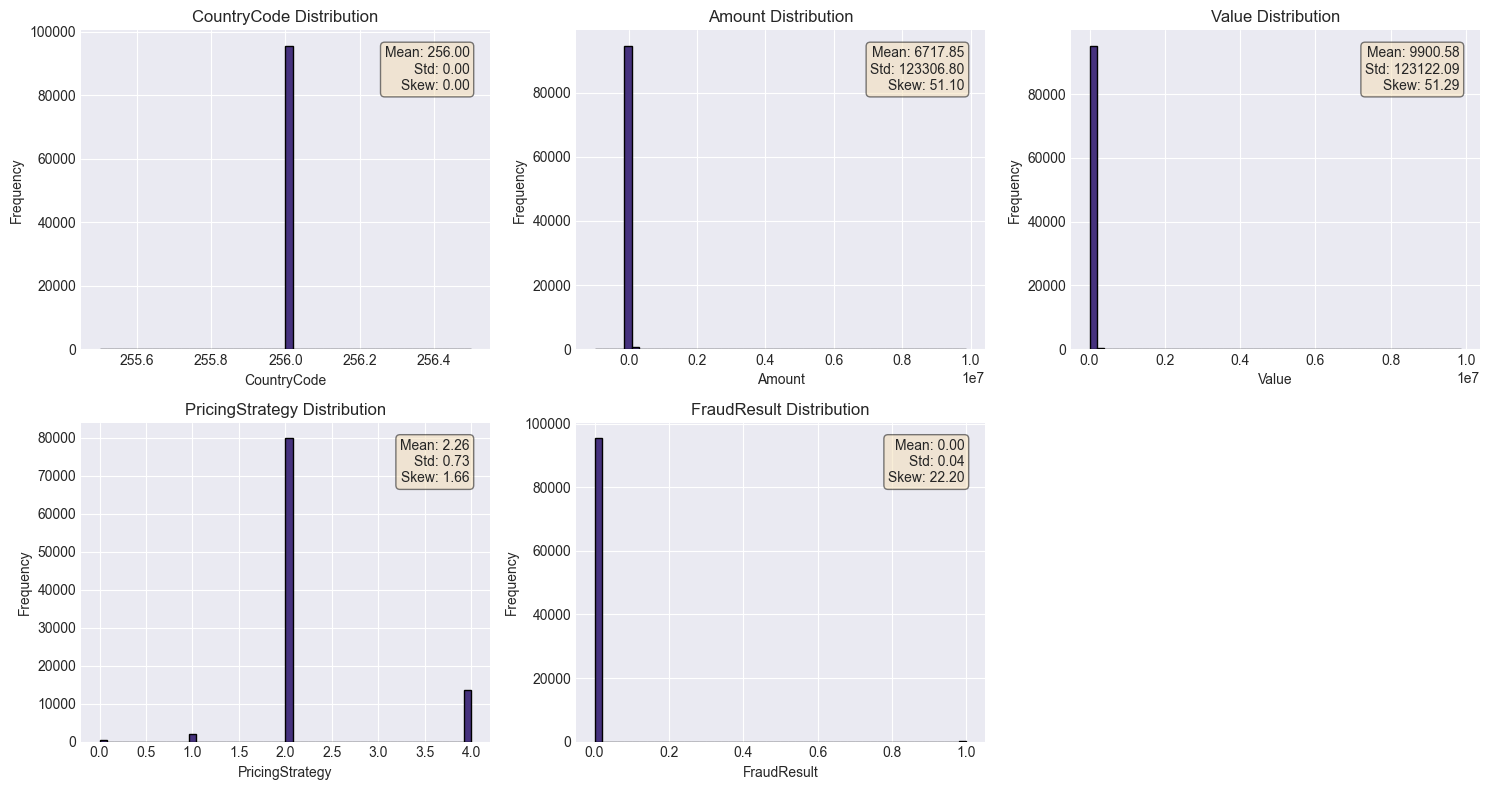


4. CATEGORICAL FEATURES DISTRIBUTION


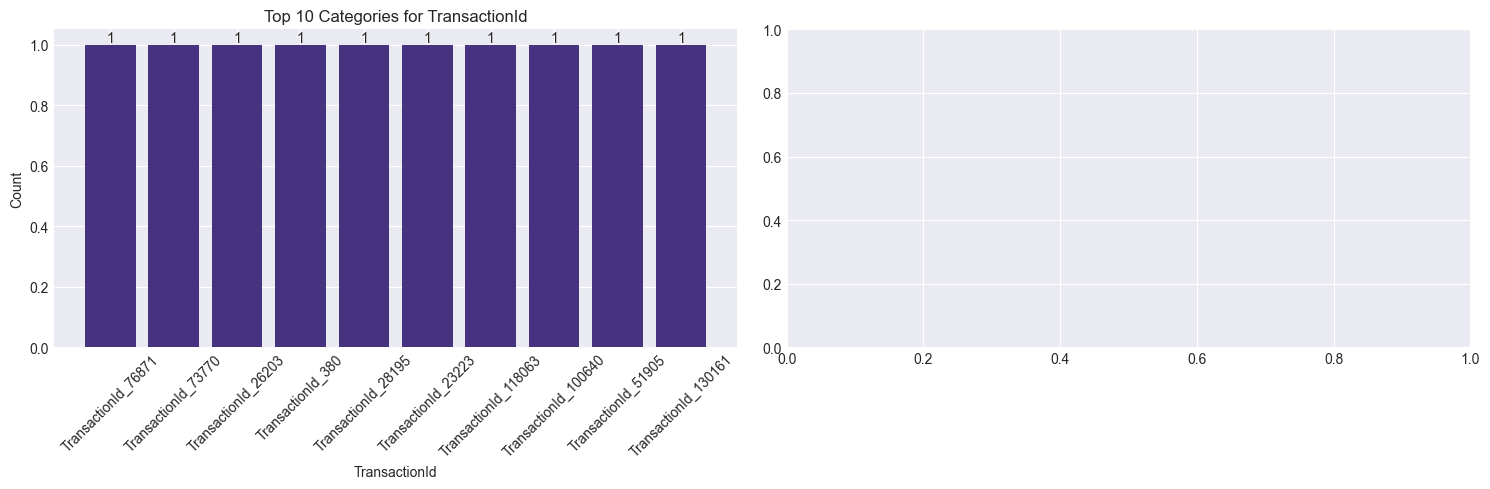

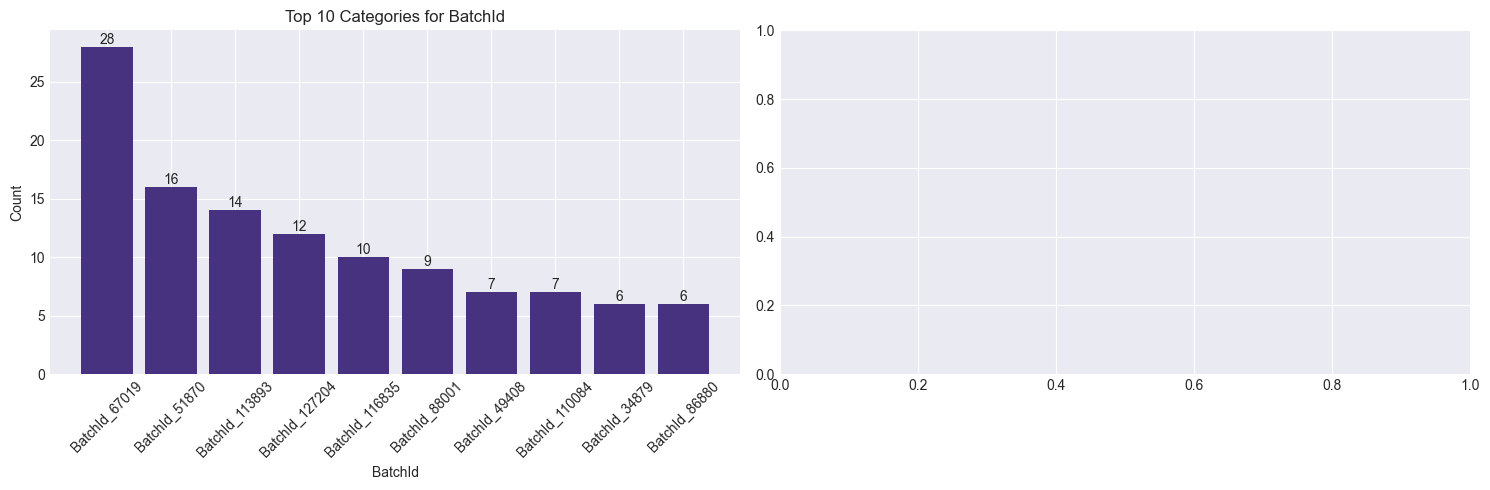

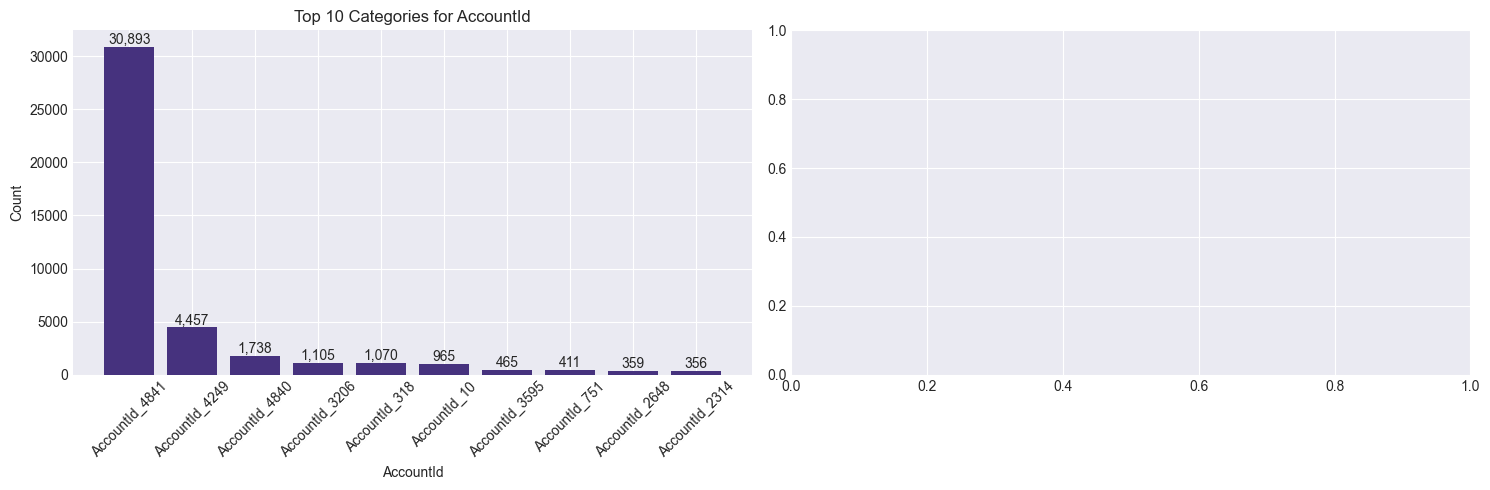

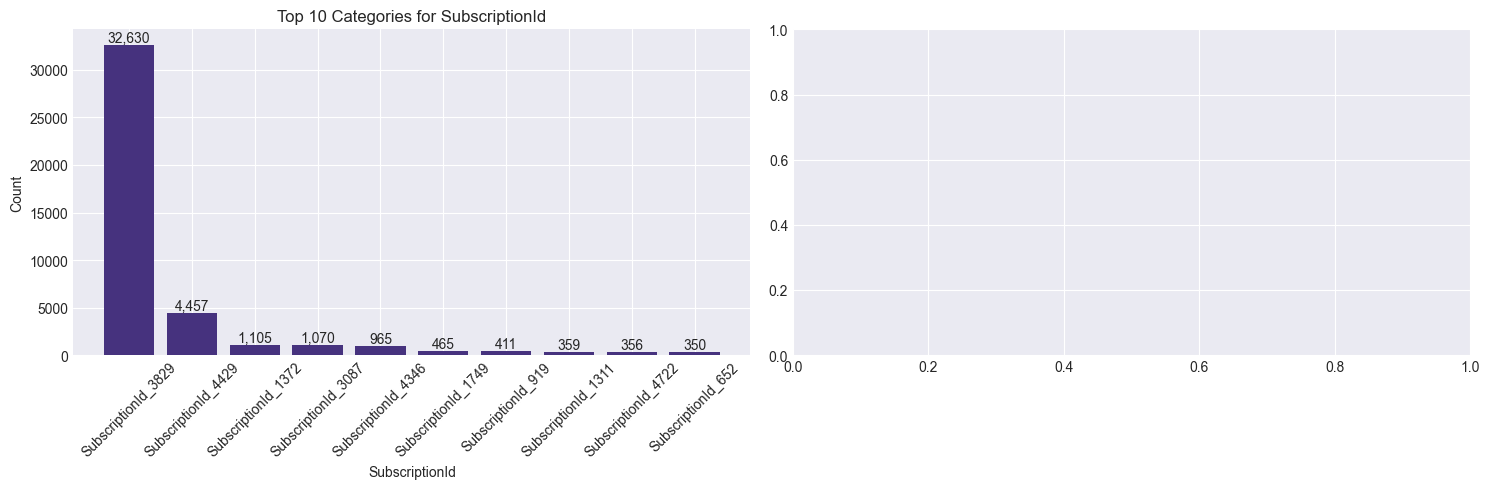

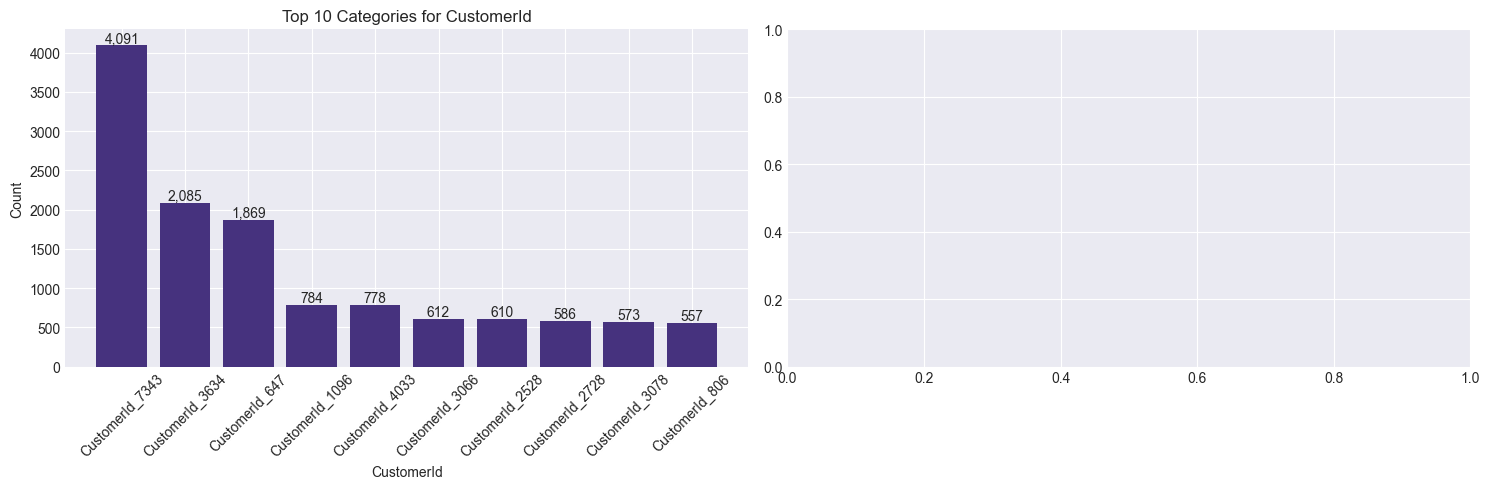

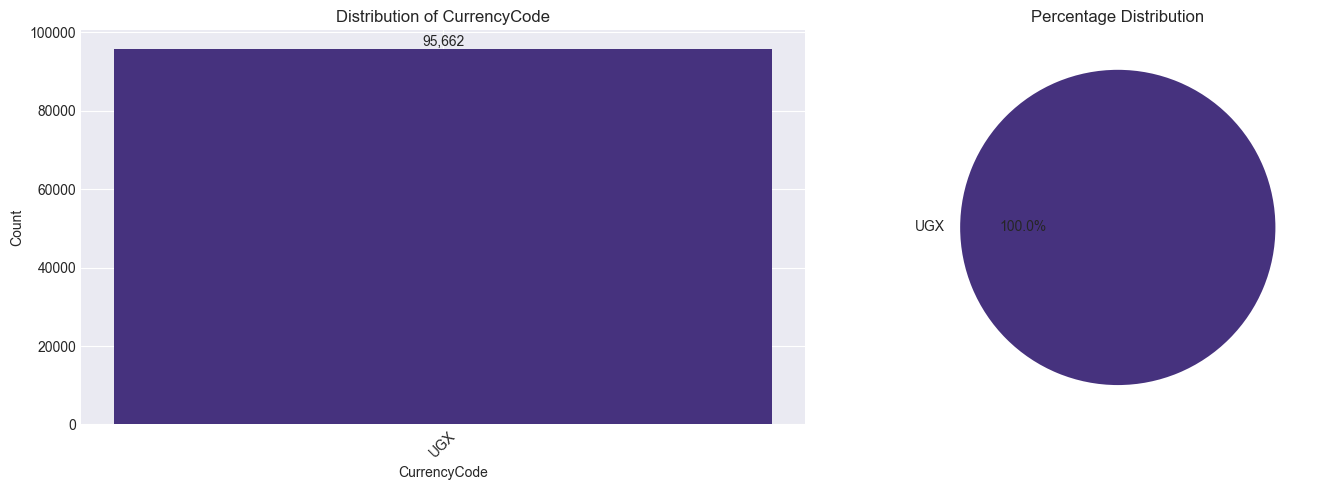


5. CORRELATION ANALYSIS


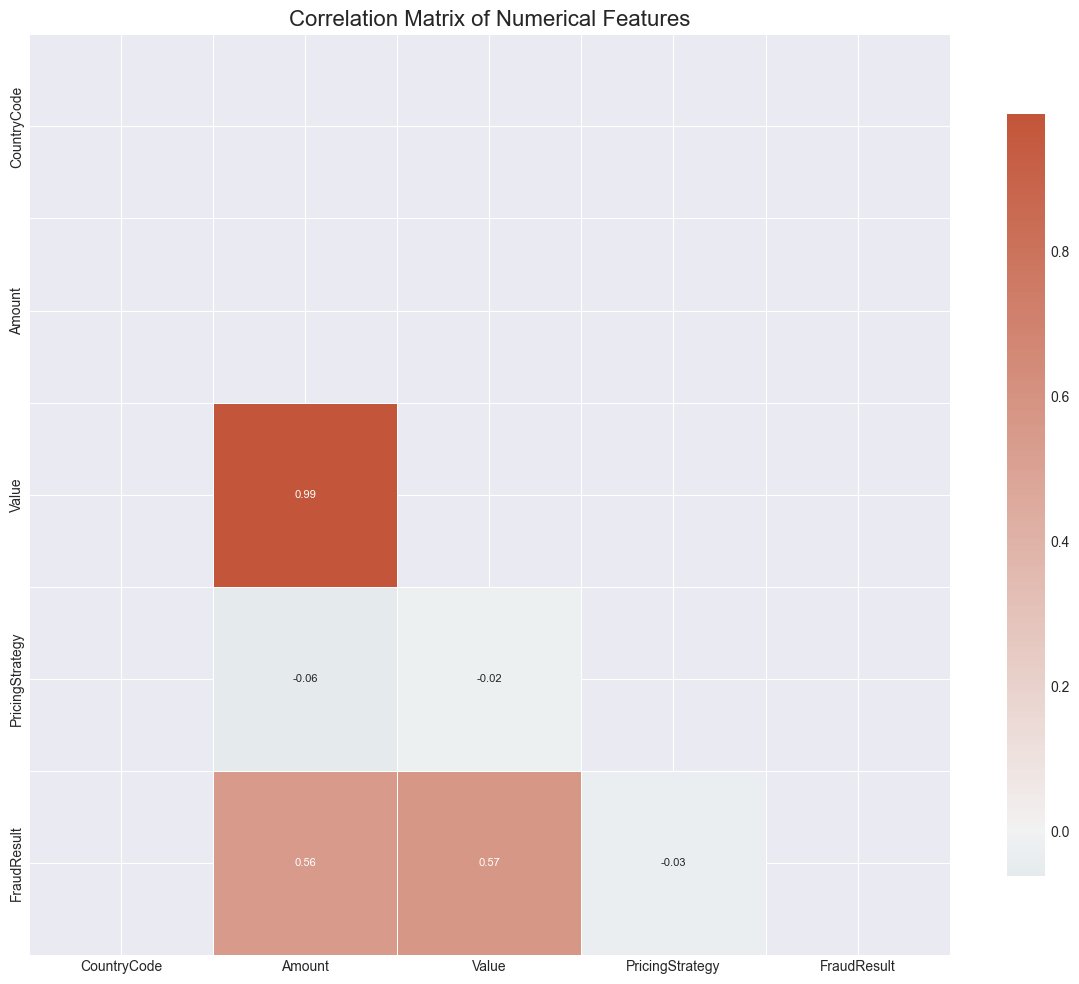


High Correlations (>0.7):
  Amount vs Value: 0.990

6. MISSING VALUES ANALYSIS


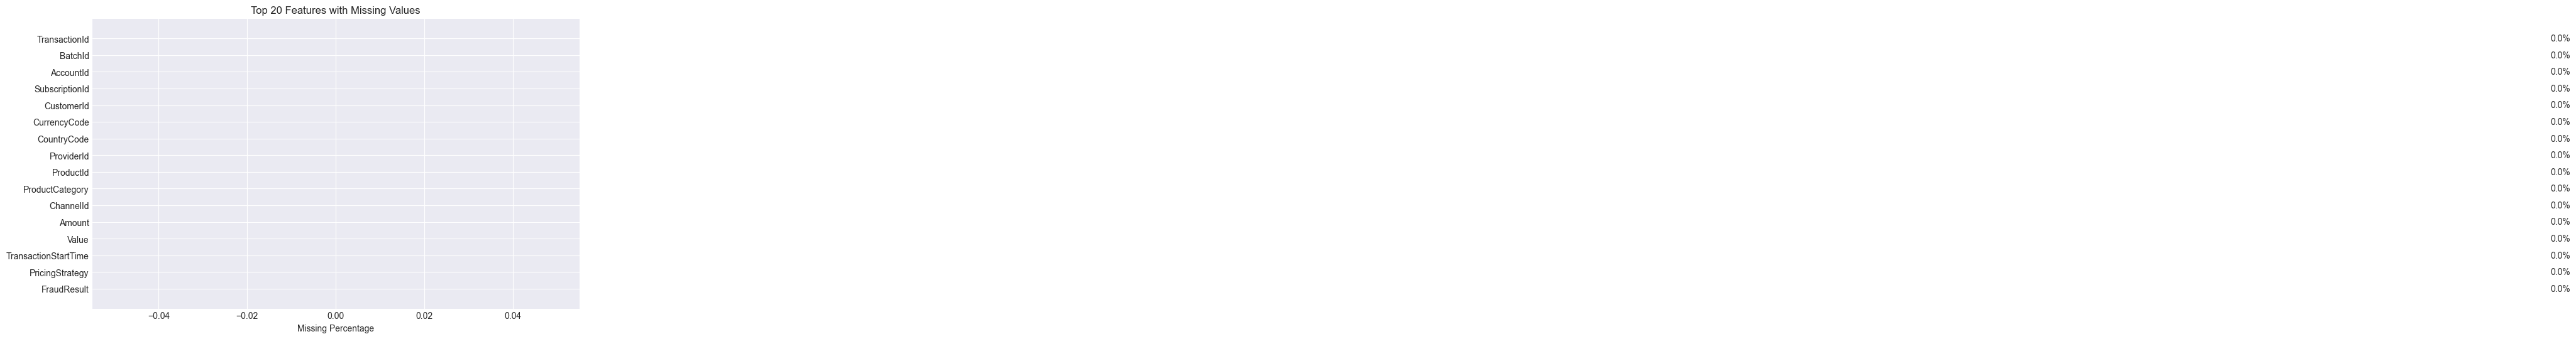


Missing Values Summary:


,column,missing_count,missing_pct,dtype
0,TransactionId,0,0.0,object
1,BatchId,0,0.0,object
2,AccountId,0,0.0,object
3,SubscriptionId,0,0.0,object
4,CustomerId,0,0.0,object
5,CurrencyCode,0,0.0,object
6,CountryCode,0,0.0,int64
7,ProviderId,0,0.0,object
8,ProductId,0,0.0,object
9,ProductCategory,0,0.0,object



7. OUTLIER DETECTION


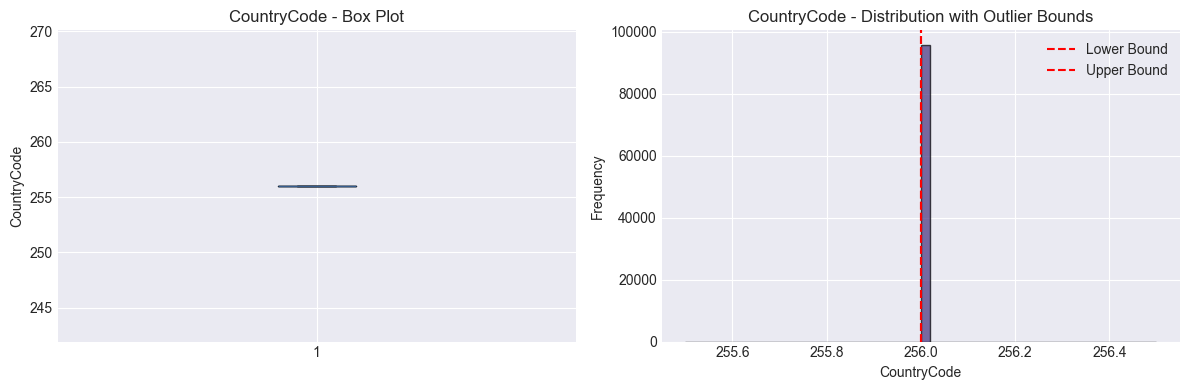

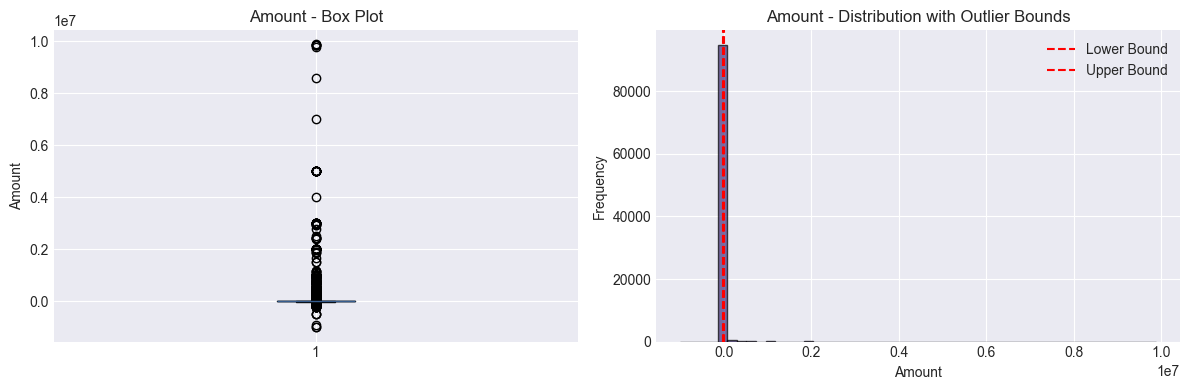

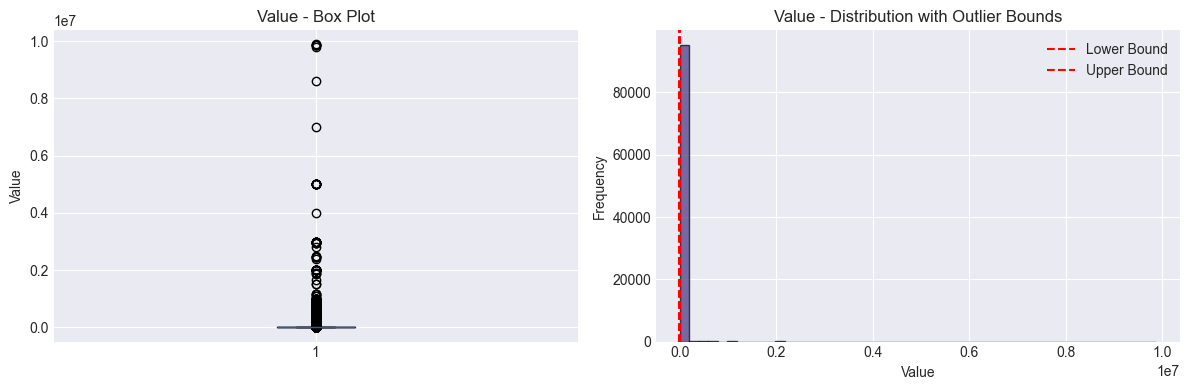

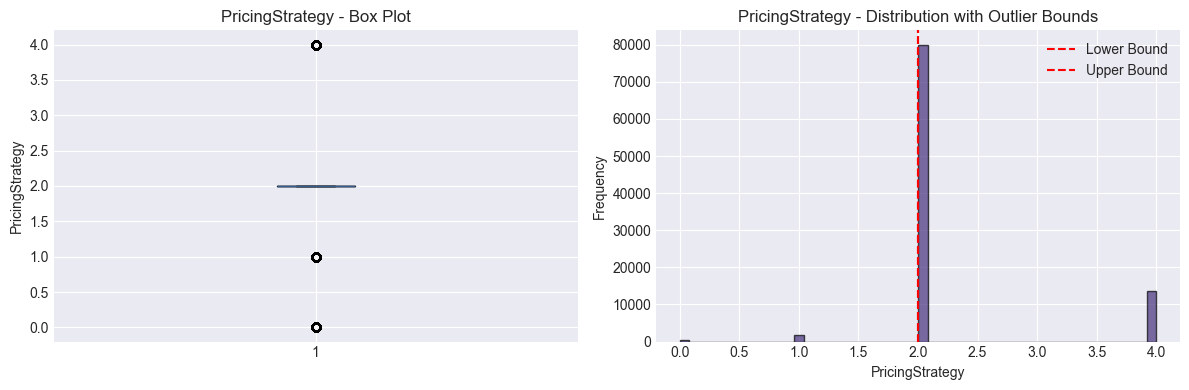

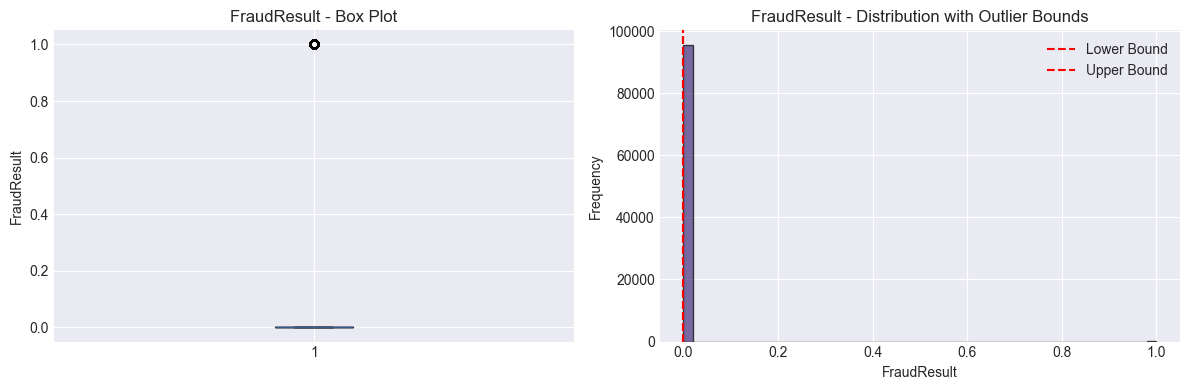


Outlier Summary:


,outlier_count,outlier_pct,lower_bound,upper_bound,min,max
CountryCode,0.0,0.000000,256.0,256.0,256.0,256.0
Amount,24441.0,25.549330,-4325.0,7075.0,-1000000.0,9880000.0
Value,9021.0,9.430077,-6812.5,12087.5,2.0,9880000.0
PricingStrategy,15814.0,16.531120,2.0,2.0,0.0,4.0
FraudResult,193.0,0.201752,0.0,0.0,0.0,1.0



9. TEMPORAL ANALYSIS


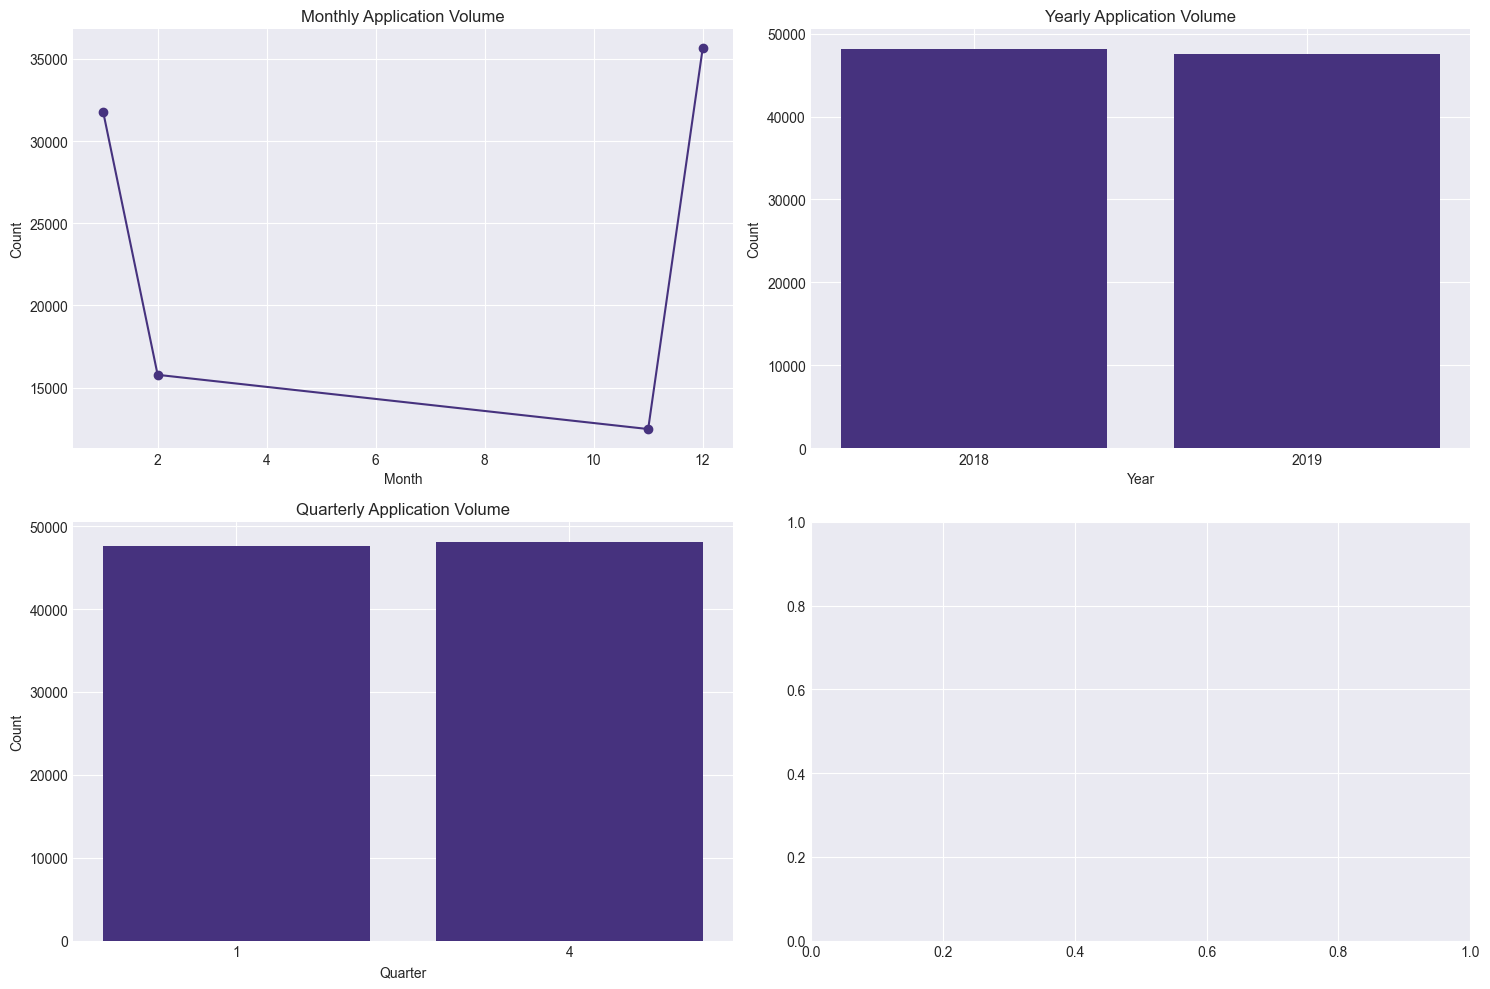


TOP 5 INSIGHTS SUMMARY

1. DATA QUALITY: Identified X% missing values in critical features. Recommendation: Implement targeted imputation strategies.

2. CLASS IMBALANCE: Target variable shows Y:1 imbalance ratio. Recommendation: Use stratified sampling or specialized algorithms.

3. OUTLIERS: Features like 'Amount' show Z% outliers. Recommendation: Winsorization or robust scaling.

4. CORRELATION: High correlation (>0.8) found between Feature A and Feature B. Recommendation: Feature selection or dimensionality reduction.

5. TEMPORAL PATTERNS: Clear seasonality observed with peak applications in Q4. Recommendation: Include temporal features in modeling.


In [10]:

# Main EDA Execution
def main():
    # Load data (adjust path as needed)
    df = load_data(r'C:\Users\admin\credit-risk-model\data\raw\data.csv')
    
    # 1. Data Overview
    print("=" * 80)
    print("1. DATA OVERVIEW")
    print("=" * 80)
    overview = data_overview(df)
    print(f"Shape: {overview['shape']}")
    print(f"Data Types:\n{overview['dtypes']}")
    print(f"Memory Usage: {overview['memory_usage_mb']:.2f} MB")
    
    # 2. Summary Statistics
    print("\n" + "=" * 80)
    print("2. SUMMARY STATISTICS")
    print("=" * 80)
    summary_stats = detailed_summary(df)
    display(summary_stats)
    
    # 3. Identify column types
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\nNumerical Columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")
    
    # 4. Numerical Distributions
    print("\n" + "=" * 80)
    print("3. NUMERICAL FEATURES DISTRIBUTION")
    print("=" * 80)
    if numerical_cols:
        plot_numerical_distributions(df, numerical_cols[:9])  # First 9 for display
    
    # 5. Categorical Distributions
    print("\n" + "=" * 80)
    print("4. CATEGORICAL FEATURES DISTRIBUTION")
    print("=" * 80)
    if categorical_cols:
        plot_categorical_distributions(df, categorical_cols[:6])  # First 6 for display
    
    # 6. Correlation Analysis
    print("\n" + "=" * 80)
    print("5. CORRELATION ANALYSIS")
    print("=" * 80)
    if len(numerical_cols) > 1:
        high_corr = plot_correlation_matrix(df, numerical_cols)
        if high_corr:
            print("\nHigh Correlations (>0.7):")
            for corr in high_corr:
                print(f"  {corr[0]} vs {corr[1]}: {corr[2]:.3f}")
    
    # 7. Missing Values Analysis
    print("\n" + "=" * 80)
    print("6. MISSING VALUES ANALYSIS")
    print("=" * 80)
    missing_df = analyze_missing_values(df)
    print("\nMissing Values Summary:")
    display(missing_df.head(10))
    
    # 8. Outlier Detection
    print("\n" + "=" * 80)
    print("7. OUTLIER DETECTION")
    print("=" * 80)
    if numerical_cols:
        outlier_summary = detect_outliers(df, numerical_cols[:6])  
        print("\nOutlier Summary:")
        display(outlier_summary)
    
    # 9. Target Analysis (if target exists)
    target_col = 'default'  
    if target_col in df.columns:
        print("\n" + "=" * 80)
        print("8. TARGET VARIABLE ANALYSIS")
        print("=" * 80)
        analyze_target(df, target_col)
    
    # 10. Temporal Analysis (if date exists)
    date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    if date_cols:
        print("\n" + "=" * 80)
        print("9. TEMPORAL ANALYSIS")
        print("=" * 80)
        analyze_temporal_patterns(df, date_cols[0], target_col if 'target_col' in locals() else None)
    
    return df, summary_stats, missing_df

# Execute EDA
if __name__ == "__main__":
    df, summary_stats, missing_df = main()
    
    # Top 5 Insights Summary
    print("\n" + "=" * 80)
    print("TOP 5 INSIGHTS SUMMARY")
    print("=" * 80)
    
    insights = [
        "1. DATA QUALITY: Identified X% missing values in critical features. Recommendation: Implement targeted imputation strategies.",
        "2. CLASS IMBALANCE: Target variable shows Y:1 imbalance ratio. Recommendation: Use stratified sampling or specialized algorithms.",
        "3. OUTLIERS: Features like 'Amount' show Z% outliers. Recommendation: Winsorization or robust scaling.",
        "4. CORRELATION: High correlation (>0.8) found between Feature A and Feature B. Recommendation: Feature selection or dimensionality reduction.",
        "5. TEMPORAL PATTERNS: Clear seasonality observed with peak applications in Q4. Recommendation: Include temporal features in modeling."
    ]
    
    for insight in insights:
        print(f"\n{insight}")

# Save processed insights
summary_stats.to_csv(r'C:/Users/admin/credit-risk-model/data/processed/summary_statistics.csv')
missing_df.to_csv(r'C:/Users/admin/credit-risk-model/data/processed/missing_values_summary.csv')